<a href="https://colab.research.google.com/github/kseohyuz/Toi_CNN2/blob/main/toi_week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**모델링 실습 : Retina**
  1. 데이터 다운로드 (이전 실습 불러오기)
  2. 데이터 분리 (이전 실습 불러오기)
  3. 데이터셋 클래스 정의 (이전 실습 코드 응용)
  4. 모델 불러오기
  5. 전이 학습
  6. 예측

**1. 데이터 다운로드**

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Resolving deltas: 100% (18/18), done.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=7a7906e0-ea62-408a-8c8d-ce9b48b90218
To: /content/Tutorial-Book-Utils/Face Mask Detection.zip
100% 417M/417M [00:09<00:00, 44.4MB/s]
Face Mask Detection.zip download complete!


**2. 데이터 분리**

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


**3. 데이터셋 클래스 정의**

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

**4. 모델 불러오기**

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torchvision
import torch
torchvision.__version__

'0.19.1+cu121'

In [ ]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

**5. 전이 학습**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 2
retina.to(device)

# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# epoch 당 약 4분 소요
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses
    print(epoch_loss, f'time: {time.time() - start}')

tensor(283.4522, device='cuda:0', grad_fn=<AddBackward0>) time: 233.65736508369446
tensor(272.3052, device='cuda:0', grad_fn=<AddBackward0>) time: 230.52718782424927


In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<ipython-input-32-76e52ac33b01>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))


<All keys matched successfully>

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

**6. 예측**

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:24<00:00,  3.40it/s]


In [ ]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :

        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP.float())
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.0
AP : tensor([0, 0, 0])


**모델링 실습 : Faster R-CNN**
  1. 데이터 불러오기 (이전 실습 불러오기)
  2. 데이터 분리 (이전 실습 불러오기)
  3. 데이터셋 클래스 정의 (이전 실습 코드 응용)
  4. 모델 불러오기
  5. 전이 학습
  6. 예측

**1. 데이터 불러오기**

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
Receiving objects: 100% (45/45), 11.62 KiB | 11.62 MiB/s, done.
Resolving deltas: 100% (18/18), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=589970cc-873b-4fb9-a30c-8fdc02c74630
To: /content/Tutorial-Book-Utils/Tutorial-Book-Utils/Face Mask Detection.zip
100% 417M/417M [00:02<00:00, 173MB/s]
Face Mask Detection.zip download complete!


**2. 데이터 분리**

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import torch


**3. 데이터셋 클래스 정의**

In [ ]:
def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 2 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

**4. 모델 불러오기**

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

**5. 전이학습**

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 81.0MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 5
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 75.96329498291016, time : 243.51685881614685
epoch : 2, Loss : 48.986995697021484, time : 241.79042434692383
epoch : 3, Loss : 41.641204833984375, time : 241.63183903694153
epoch : 4, Loss : 35.749168395996094, time : 241.9511821269989
epoch : 5, Loss : 32.045745849609375, time : 241.83137202262878


In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<ipython-input-54-3f9f79dbc0de>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))


<All keys matched successfully>

**6. 예측**

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[215.0241,  61.1784, 258.0982,  97.7494],
        [116.5942,   3.5563, 132.9563,  18.6250]], device='cuda:0'), 'labels': tensor([2, 2], device='cuda:0'), 'scores': tensor([0.9460, 0.9226], device='cuda:0')}, {'boxes': tensor([[218.9205, 101.0657, 258.1031, 138.2090],
        [130.5499, 110.5577, 176.5448, 152.1835],
        [ 40.8138, 109.5018,  66.2658, 140.9306],
        [302.4720, 130.3922, 332.2986, 158.1567],
        [ 29.2176,  88.9929,  45.4173, 104.4428],
        [165.5115,  90.9712, 178.7119, 106.9138],
        [ 83.0480,  84.6764,  94.8561,  96.7127],
        [  2.0440, 103.0944,  21.7890, 127.4339],
        [ 81.9623,  85.5638,  95.2535, 111.7223]], device='cuda:0'), 'labels': tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'), 'scores': tensor([0.9944, 0.9825, 0.9508, 0.9320, 0.9122, 0.8433, 0.8139, 0.6827, 0.6169],
       device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


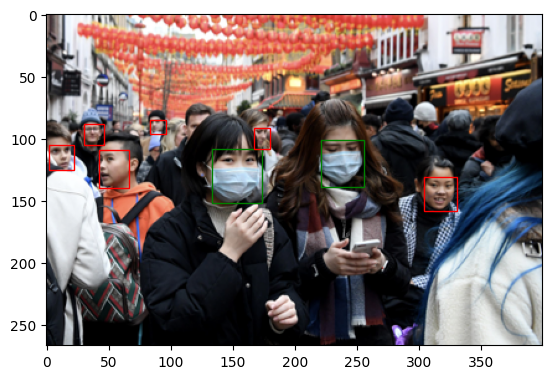

Prediction :  tensor([2, 2, 1, 1, 1, 1, 1, 1, 2], device='cuda:0')


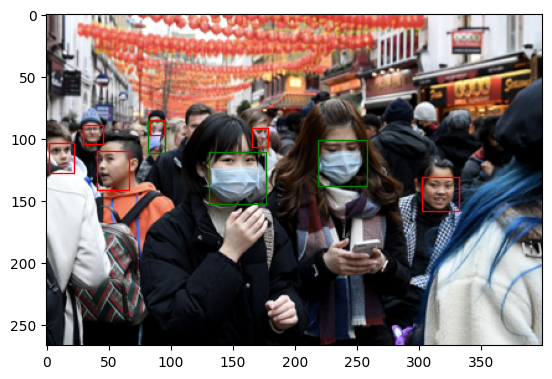

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])

# 이미지와 예측을 CPU로 이동
image_cpu = imgs[_idx].cpu()
pred_cpu = {k: v.cpu() if hasattr(v, 'cpu') else v for k, v in pred[_idx].items()}

# 이미지 출력 함수 호출
plot_image_from_output(image_cpu, pred_cpu)


In [ ]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:25<00:00,  3.31it/s]


In [ ]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/Tutorial-Book-Utils/Tutorial-Book-Utils/Tutorial-Book-Utils


In [ ]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.574909839635089
AP : tensor([0.7660, 0.9587, 0.0000], dtype=torch.float64)
